In [3]:
import os, re
import pandas as pd
from google.cloud import bigquery
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

GCP_PROJECT_ID = 'is3107-453814'
BQ_DATASET_ID = 'car_dataset'
BQ_TABLE_ID = 'used_car'
BUCKET_NAME = 'is3107-bucket'

os.environ['GOOGLE_APPLICATION_CREDENTIALS']=r'Airflow\config\gcp-key.json'

In [2]:
def read_bq_to_df(gcp_project_id, bq_dataset_id, bq_table_id, limit=100):
    client = bigquery.Client(project=gcp_project_id)
    table_ref = f"{gcp_project_id}.{bq_dataset_id}.{bq_table_id}"

    table_key = f"{bq_dataset_id}.{bq_table_id}"
    query = f"SELECT * FROM {table_key} WHERE used_car_id IS NOT NULL AND listing_url IS NOT NULL AND car_model IS NOT NULL AND brand IS NOT NULL AND color IS NOT NULL AND fuel_type IS NOT NULL AND price IS NOT NULL AND depreciation_per_year IS NOT NULL AND registration_date IS NOT NULL AND coe_left IS NOT NULL AND mileage IS NOT NULL AND manufactured_year IS NOT NULL AND road_tax_per_year IS NOT NULL AND transmission IS NOT NULL AND dereg_value IS NOT NULL AND omv IS NOT NULL AND coe_value IS NOT NULL AND arf IS NOT NULL AND engine_capacity_cc IS NOT NULL AND power IS NOT NULL AND curb_weight IS NOT NULL AND no_of_owners IS NOT NULL AND vehicle_type IS NOT NULL AND scraped_datetime IS NOT NULL AND posted_datetime IS NOT NULL AND updated_datetime IS NOT NULL AND active IS NOT NULL"
    df = client.query(query).to_dataframe()
    return df

In [18]:
df = read_bq_to_df(GCP_PROJECT_ID, BQ_DATASET_ID, BQ_TABLE_ID, 200)

In [19]:
df.to_csv('used_car.csv', index=False)

In [6]:
df = pd.read_csv('used_car.csv')

In [4]:
def initial_data_cleaning(df):
    """Performs initial cleaning on used car DataFrame.
    
    Args:
        df (pd.DataFrame): Raw used car data
        
    Returns:
        pd.DataFrame: Cleaned DataFrame ready for further processing
    """
    df = df.copy()

    # Data Cleaning 1: Remove duplicates
    df.drop_duplicates(inplace=True)

    # Data Cleaning 2: Drop where active==False -> this is when in the future we have future training where we want to set certain dataset/entries to be False
    df = df[df['active'].astype(bool)]

    # Data Cleaning 2: Remove listing_url, active column as it should not be a feature in ML except used_car_id as it is used for future reference
    df.drop(columns=['listing_url', 'active'], inplace=True)

    # Data Cleaning 3: Convert scraped_datetime, posted_datetime, updated_datetime to datetime
    datetime_cols = ['scraped_datetime', 'posted_datetime', 'updated_datetime']
    df[datetime_cols] = df[datetime_cols].apply(pd.to_datetime)

    return df

In [7]:
df_cleaned = initial_data_cleaning(df)
df_cleaned.head()

,used_car_id,car_model,brand,color,fuel_type,price,depreciation_per_year,registration_date,coe_left,mileage,...,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,scraped_datetime,posted_datetime,updated_datetime
0,1322197,B.M.W. M3 CSL,B.M.W.,Grey,Petrol,450000.0,52920.0,2003-12-27,3099,69200,...,122414.0,161026.0,3246,261,1460,4,Sports Car,2025-04-01 11:36:29.442442,2025-02-11,2025-03-05
1,1329472,FERRARI CSTRADALE360,FERRARI,Blue,Petrol,888000.0,102380.0,2003-12-12,3159,29000,...,138094.0,286342.0,3586,305,1290,2,Sports Car,2025-04-01 01:58:17.105366,2025-03-08,2025-03-08
2,1367766,TOYOTA LEXUS IS 200,TOYOTA,Grey,Petrol,108888.0,13190.0,2003-09-20,3010,135000,...,117255.0,39631.0,1988,114,1440,2,Luxury Sedan,2025-03-31 16:27:37.511739,2025-03-21,2025-03-21
3,1226661,BENTLEY CONTI GT,BENTLEY,White,Petrol,180800.0,20080.0,2004-05-03,3277,46000,...,106075.0,274637.0,5998,412,2410,6,Sports Car,2025-04-01 02:03:25.055446,2025-03-08,2025-03-08
4,1333164,FERRARI 575MARANELLO,FERRARI,Red,Petrol,450000.0,48050.0,2004-08-11,3414,64700,...,102423.0,285379.0,5748,380,1825,4,Sports Car,2025-04-01 02:44:44.586252,2025-03-05,2025-03-05


In [11]:
def check_columns(df):
    """Prints detailed column information"""
    print("=== COLUMN REPORT ===")
    print(f"Total columns: {len(df.columns)}")
    print("\nColumn names and data types:")
    print(df.dtypes)
    print("\nMissing values per column:")
    print(df.isnull().sum())

check_columns(df_cleaned)

=== COLUMN REPORT ===
Total columns: 24

Column names and data types:
car_model                        object
brand                            object
color                            object
fuel_type                        object
price                           float64
depreciation_per_year           float64
registration_date                object
coe_left                          int64
mileage                           int64
manufactured_year                 int64
road_tax_per_year               float64
transmission                     object
dereg_value                     float64
omv                             float64
coe_value                       float64
arf                             float64
engine_capacity_cc                int64
power                             int64
curb_weight                       int64
no_of_owners                      int64
vehicle_type                     object
scraped_datetime         datetime64[ns]
posted_datetime          datetime64[ns]
updated_da

In [8]:
def feature_engineer_car_age(df):
    """Adds a new column 'car_age' to the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing car data
        
    Returns:
        pd.DataFrame: DataFrame with 'car_age' column added
    """
    current_year = pd.to_datetime('now').year
    df = df.copy()
    df['car_age'] = current_year - df['manufactured_year']

    df.drop(columns=['manufactured_year'], inplace=True)
    
    return df

In [9]:
df_with_car_age = feature_engineer_car_age(df_cleaned)

df_with_car_age.head()

,used_car_id,car_model,brand,color,fuel_type,price,depreciation_per_year,registration_date,coe_left,mileage,...,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,scraped_datetime,posted_datetime,updated_datetime,car_age
0,1322197,B.M.W. M3 CSL,B.M.W.,Grey,Petrol,450000.0,52920.0,2003-12-27,3099,69200,...,161026.0,3246,261,1460,4,Sports Car,2025-04-01 11:36:29.442442,2025-02-11,2025-03-05,22
1,1329472,FERRARI CSTRADALE360,FERRARI,Blue,Petrol,888000.0,102380.0,2003-12-12,3159,29000,...,286342.0,3586,305,1290,2,Sports Car,2025-04-01 01:58:17.105366,2025-03-08,2025-03-08,22
2,1367766,TOYOTA LEXUS IS 200,TOYOTA,Grey,Petrol,108888.0,13190.0,2003-09-20,3010,135000,...,39631.0,1988,114,1440,2,Luxury Sedan,2025-03-31 16:27:37.511739,2025-03-21,2025-03-21,22
3,1226661,BENTLEY CONTI GT,BENTLEY,White,Petrol,180800.0,20080.0,2004-05-03,3277,46000,...,274637.0,5998,412,2410,6,Sports Car,2025-04-01 02:03:25.055446,2025-03-08,2025-03-08,21
4,1333164,FERRARI 575MARANELLO,FERRARI,Red,Petrol,450000.0,48050.0,2004-08-11,3414,64700,...,285379.0,5748,380,1825,4,Sports Car,2025-04-01 02:44:44.586252,2025-03-05,2025-03-05,21


In [10]:
def feature_engineer_temporal_features(df):
    df = df.copy()
    
    # 1. Days on market
    df['days_on_market'] = (df['scraped_datetime'] - df['posted_datetime']).dt.days
    
    # Drop original datetime columns (optional)
    df.drop(columns=['posted_datetime', 'scraped_datetime', 'updated_datetime', 'registration_date'], inplace=True)
    
    return df


In [11]:
df_temporal = feature_engineer_temporal_features(df_with_car_age)
df_temporal.head()

,used_car_id,car_model,brand,color,fuel_type,price,depreciation_per_year,coe_left,mileage,road_tax_per_year,...,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,car_age,days_on_market
0,1322197,B.M.W. M3 CSL,B.M.W.,Grey,Petrol,450000.0,52920.0,3099,69200,4155.0,...,123866.0,122414.0,161026.0,3246,261,1460,4,Sports Car,22,49
1,1329472,FERRARI CSTRADALE360,FERRARI,Blue,Petrol,888000.0,102380.0,3159,29000,4953.0,...,220263.0,138094.0,286342.0,3586,305,1290,2,Sports Car,22,24
2,1367766,TOYOTA LEXUS IS 200,TOYOTA,Grey,Petrol,108888.0,13190.0,3010,135000,1800.0,...,30485.0,117255.0,39631.0,1988,114,1440,2,Luxury Sedan,22,10
3,1226661,BENTLEY CONTI GT,BENTLEY,White,Petrol,180800.0,20080.0,3277,46000,10611.0,...,249670.0,106075.0,274637.0,5998,412,2410,6,Sports Car,21,24
4,1333164,FERRARI 575MARANELLO,FERRARI,Red,Petrol,450000.0,48050.0,3414,64700,10026.0,...,259435.0,102423.0,285379.0,5748,380,1825,4,Sports Car,21,27


In [12]:
def feature_engineer_clean_model_name(df):
    # Standardize to lowercase, remove punctuation/extra spaces
    df = df.copy()
    df['car_model'] = df['car_model'].apply(lambda x:  re.sub(r'[^\w\s]', '', str(x).lower().strip()))
    return df

In [13]:
df_cleaned_model = feature_engineer_clean_model_name(df_temporal)
print(df_cleaned_model['car_model'].nunique())
df_cleaned_model.head()


3125


,used_car_id,car_model,brand,color,fuel_type,price,depreciation_per_year,coe_left,mileage,road_tax_per_year,...,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,car_age,days_on_market
0,1322197,bmw m3 csl,B.M.W.,Grey,Petrol,450000.0,52920.0,3099,69200,4155.0,...,123866.0,122414.0,161026.0,3246,261,1460,4,Sports Car,22,49
1,1329472,ferrari cstradale360,FERRARI,Blue,Petrol,888000.0,102380.0,3159,29000,4953.0,...,220263.0,138094.0,286342.0,3586,305,1290,2,Sports Car,22,24
2,1367766,toyota lexus is 200,TOYOTA,Grey,Petrol,108888.0,13190.0,3010,135000,1800.0,...,30485.0,117255.0,39631.0,1988,114,1440,2,Luxury Sedan,22,10
3,1226661,bentley conti gt,BENTLEY,White,Petrol,180800.0,20080.0,3277,46000,10611.0,...,249670.0,106075.0,274637.0,5998,412,2410,6,Sports Car,21,24
4,1333164,ferrari 575maranello,FERRARI,Red,Petrol,450000.0,48050.0,3414,64700,10026.0,...,259435.0,102423.0,285379.0,5748,380,1825,4,Sports Car,21,27


In [14]:
def feature_engineer_car_model_embedding(df):
    df = df.copy()
    # Load pretrained model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    df['car_model_embedding'] = list(model.encode(df['car_model'].astype(str)))
    return df

In [15]:
df_embedded = feature_engineer_car_model_embedding(df_cleaned_model)
df_embedded.head()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


,used_car_id,car_model,brand,color,fuel_type,price,depreciation_per_year,coe_left,mileage,road_tax_per_year,...,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,car_age,days_on_market,car_model_embedding
0,1322197,bmw m3 csl,B.M.W.,Grey,Petrol,450000.0,52920.0,3099,69200,4155.0,...,122414.0,161026.0,3246,261,1460,4,Sports Car,22,49,"[-0.072149485, 0.07592694, -0.04695741, 0.0207..."
1,1329472,ferrari cstradale360,FERRARI,Blue,Petrol,888000.0,102380.0,3159,29000,4953.0,...,138094.0,286342.0,3586,305,1290,2,Sports Car,22,24,"[-0.048727863, 0.040641315, -0.13958336, 0.046..."
2,1367766,toyota lexus is 200,TOYOTA,Grey,Petrol,108888.0,13190.0,3010,135000,1800.0,...,117255.0,39631.0,1988,114,1440,2,Luxury Sedan,22,10,"[-0.0076985843, 0.022889072, -0.01552978, -0.0..."
3,1226661,bentley conti gt,BENTLEY,White,Petrol,180800.0,20080.0,3277,46000,10611.0,...,106075.0,274637.0,5998,412,2410,6,Sports Car,21,24,"[-0.10554662, 0.055305347, -0.052193843, 0.024..."
4,1333164,ferrari 575maranello,FERRARI,Red,Petrol,450000.0,48050.0,3414,64700,10026.0,...,102423.0,285379.0,5748,380,1825,4,Sports Car,21,27,"[-0.0704206, 0.10031793, -0.09348111, 0.098243..."


## Experimentation on using TF-IDF + K-Means
The code below was to feature engineer and hyperparemeter tune K-means by using a TF-IDF variable of 'car_model'
However it lacks an identifiable elbow point that allow us to choose a suitable cluster number.
The sum of squared distance between the centroids and its points decreases in a linear manner which when we set up a grid search from 100 to 1000 clusters.

In [16]:
# tfidf = TfidfVectorizer(ngram_range=(1, 2))
# X = tfidf.fit_transform(df['car_model'])
# # kmeans = KMeans(n_clusters=200)  # Adjust cluster count
# Sum_of_squared_distances = []
# K = range(100, 1000, 10)
# for k in K:
#     kmeans = KMeans(n_clusters=k)
#     df['car_model_cluster'] = kmeans.fit_predict(X)
#     Sum_of_squared_distances.append(kmeans.inertia_)

# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

# Looks to be about ~500 but there is no clear elbow point
# https://www.lta.gov.sg/content/dam/ltagov/who_we_are/statistics_and_publications/statistics/pdf/MVP01-6_Cars_by_make.pdf
## above shows about 130 different car makes in Singapore
# we will try around about 300-500 clusters

def feature_engineer_tfidf_kmeans(df):
    df = df.copy()
    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(ngram_range=(1, 2)) # an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
    X = tfidf.fit_transform(df['car_model'])
    kmeans = KMeans(n_clusters=375)  # Adjust cluster count
    df['car_model_cluster'] = kmeans.fit_predict(X)

    return df

# df_tfidf_kmeans = feature_engineer_tfidf_kmeans(df_cleaned_model)
# df_tfidf_kmeans.head()

In [17]:
# # Reduce dimensions to 2D for plotting
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X.toarray())

# # Plot
# plt.figure(figsize=(12, 8))
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_tfidf_kmeans['car_model_cluster'], cmap='tab20', s=10)
# plt.title("Car Model Clusters (t-SNE)")
# plt.xlabel("Dim 1")
# plt.ylabel("Dim 2")
# plt.colorbar(label='Cluster ID')
# plt.show()

In [18]:
final_df = df_embedded.copy()

In [19]:
def visualize_embeddings(df, method='pca'):
    # Extract embeddings
    embeddings = np.vstack(df['car_model_embedding'].values)
    

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        raise ValueError("Method must be 'pca', 'tsne'")

    reduced_embeddings = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['car_model'].astype('category').cat.codes, cmap='tab20', alpha=0.6)
    
    
    plt.title(f'Car Model Embeddings ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()


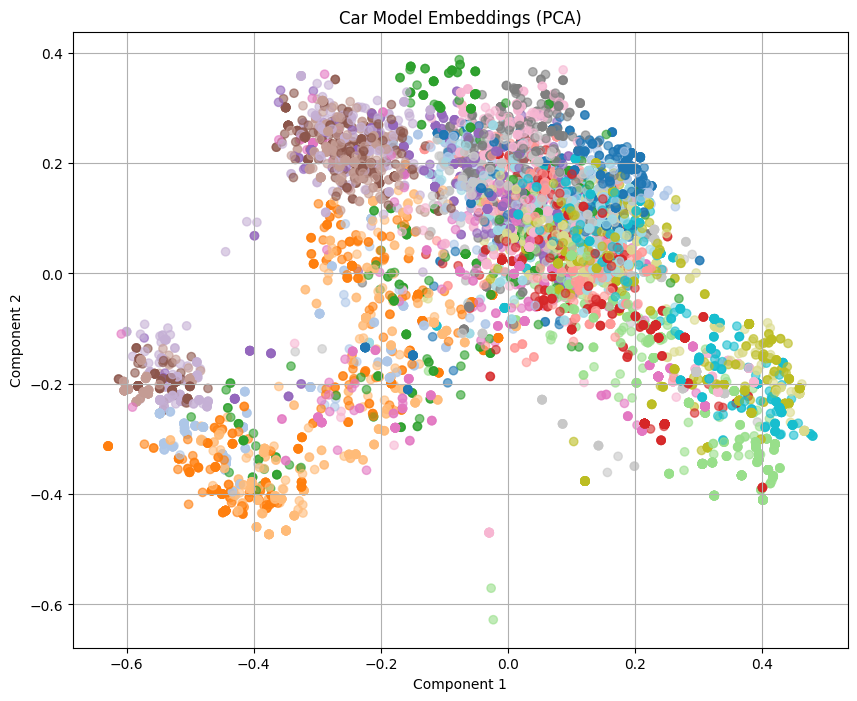

In [20]:
visualize_embeddings(final_df, method='pca')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


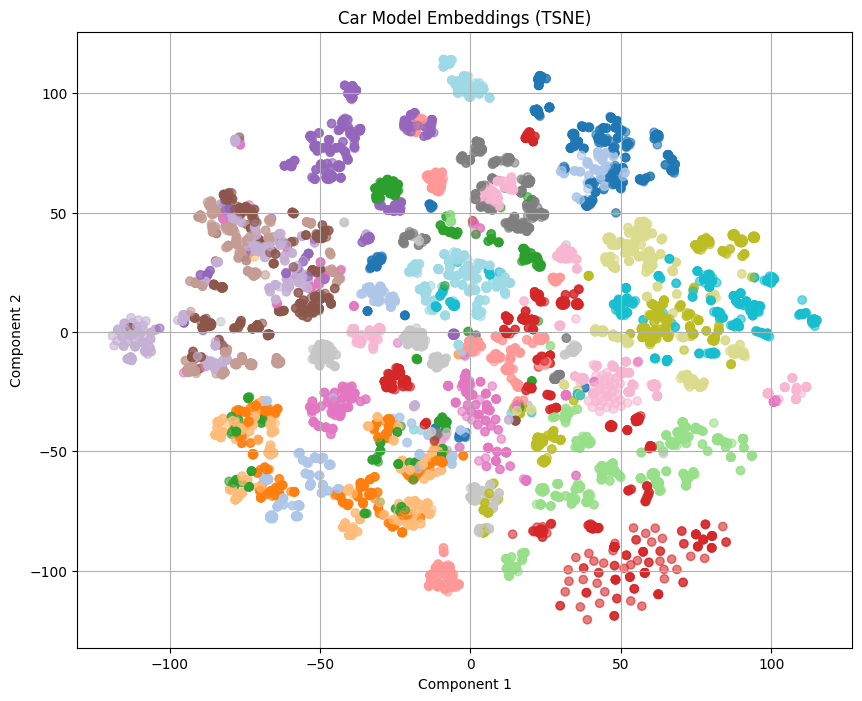

In [21]:
visualize_embeddings(final_df, method='tsne')


In [22]:
pd.set_option('display.max_columns', None)

final_df.drop(columns=['car_model'], inplace=True)
final_df.head()

,used_car_id,brand,color,fuel_type,price,depreciation_per_year,coe_left,mileage,road_tax_per_year,transmission,dereg_value,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,car_age,days_on_market,car_model_embedding
0,1322197,B.M.W.,Grey,Petrol,450000.0,52920.0,3099,69200,4155.0,Auto,97931.0,123866.0,122414.0,161026.0,3246,261,1460,4,Sports Car,22,49,"[-0.072149485, 0.07592694, -0.04695741, 0.0207..."
1,1329472,FERRARI,Blue,Petrol,888000.0,102380.0,3159,29000,4953.0,Auto,110475.0,220263.0,138094.0,286342.0,3586,305,1290,2,Sports Car,22,24,"[-0.048727863, 0.040641315, -0.13958336, 0.046..."
2,1367766,TOYOTA,Grey,Petrol,108888.0,13190.0,3010,135000,1800.0,Auto,93804.0,30485.0,117255.0,39631.0,1988,114,1440,2,Luxury Sedan,22,10,"[-0.0076985843, 0.022889072, -0.01552978, -0.0..."
3,1226661,BENTLEY,White,Petrol,180800.0,20080.0,3277,46000,10611.0,Auto,84860.0,249670.0,106075.0,274637.0,5998,412,2410,6,Sports Car,21,24,"[-0.10554662, 0.055305347, -0.052193843, 0.024..."
4,1333164,FERRARI,Red,Petrol,450000.0,48050.0,3414,64700,10026.0,Auto,81938.0,259435.0,102423.0,285379.0,5748,380,1825,4,Sports Car,21,27,"[-0.0704206, 0.10031793, -0.09348111, 0.098243..."


In [ ]:
embedding_df = pd.DataFrame(final_df["car_model_embedding"].tolist()).add_prefix("embedding_")
final_df.drop(columns=["car_model_embedding"], inplace=True)
final_df = pd.concat([final_df, embedding_df], axis=1)

KeyError: 'car_model_embedding'

In [ ]:

final_df.rename(columns={"used_car_id": "id"}, inplace=True)
final_df.head()

,id,brand,color,fuel_type,price,depreciation_per_year,coe_left,mileage,road_tax_per_year,transmission,dereg_value,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,car_age,days_on_market,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,

In [43]:
final_df.to_csv('pre-feateng_used_cars.csv', index=False)

In [38]:
final_df.head()

,id,brand,color,fuel_type,price,depreciation_per_year,coe_left,mileage,road_tax_per_year,transmission,dereg_value,omv,coe_value,arf,engine_capacity_cc,power,curb_weight,no_of_owners,vehicle_type,car_age,days_on_market,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,

Text(0.5, 1.0, 'Distribution of Car Prices')

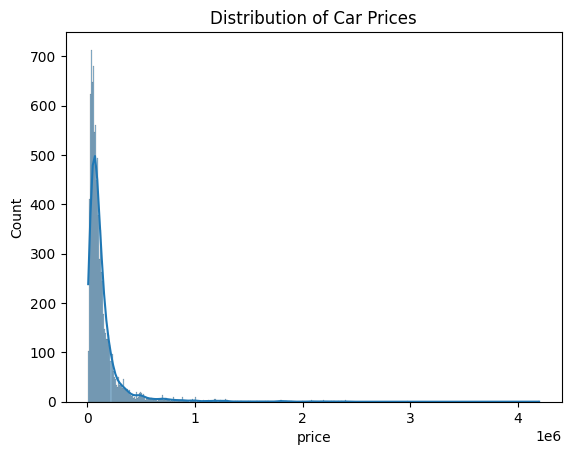

In [31]:
sns.histplot(final_df['price'], kde=True)
plt.title('Distribution of Car Prices')

## Distribution of Numerical Features

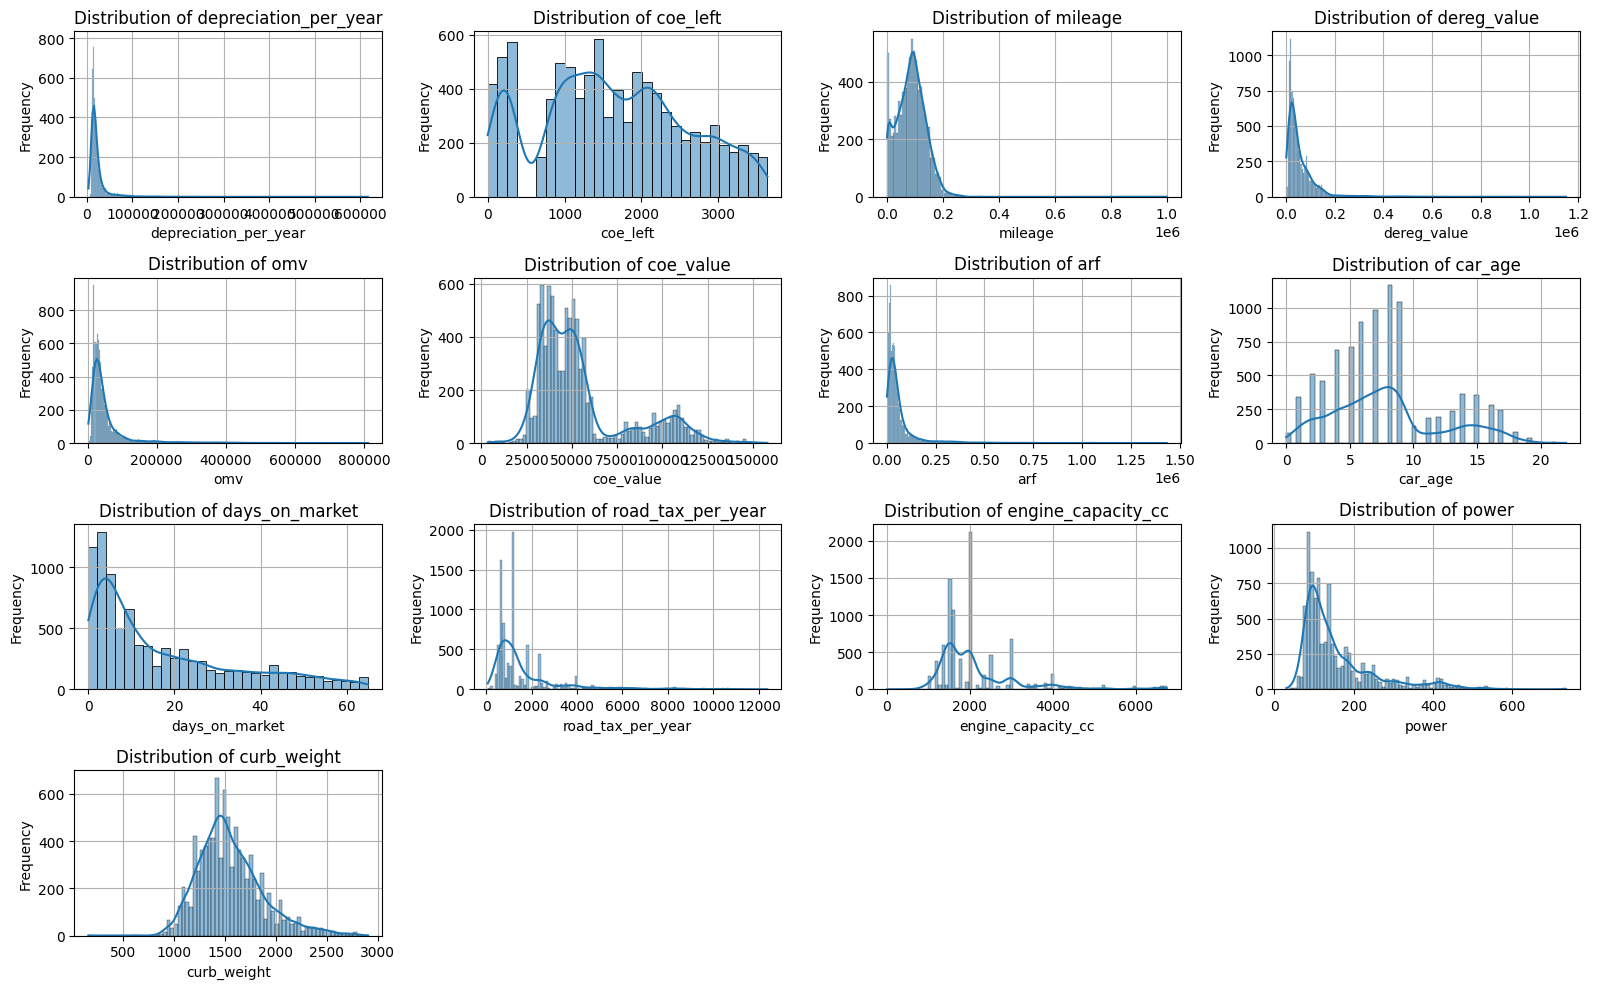

In [32]:
plt.figure(figsize=(16, 10))
numeric_cols = ['depreciation_per_year', 'coe_left', 'mileage', 'dereg_value', 'omv', 'coe_value', 'arf', 'car_age', 'days_on_market',
                'road_tax_per_year', 'engine_capacity_cc', 'power', 'curb_weight']
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(final_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
plt.tight_layout()
plt.show()

## Correlation Matrix of Features

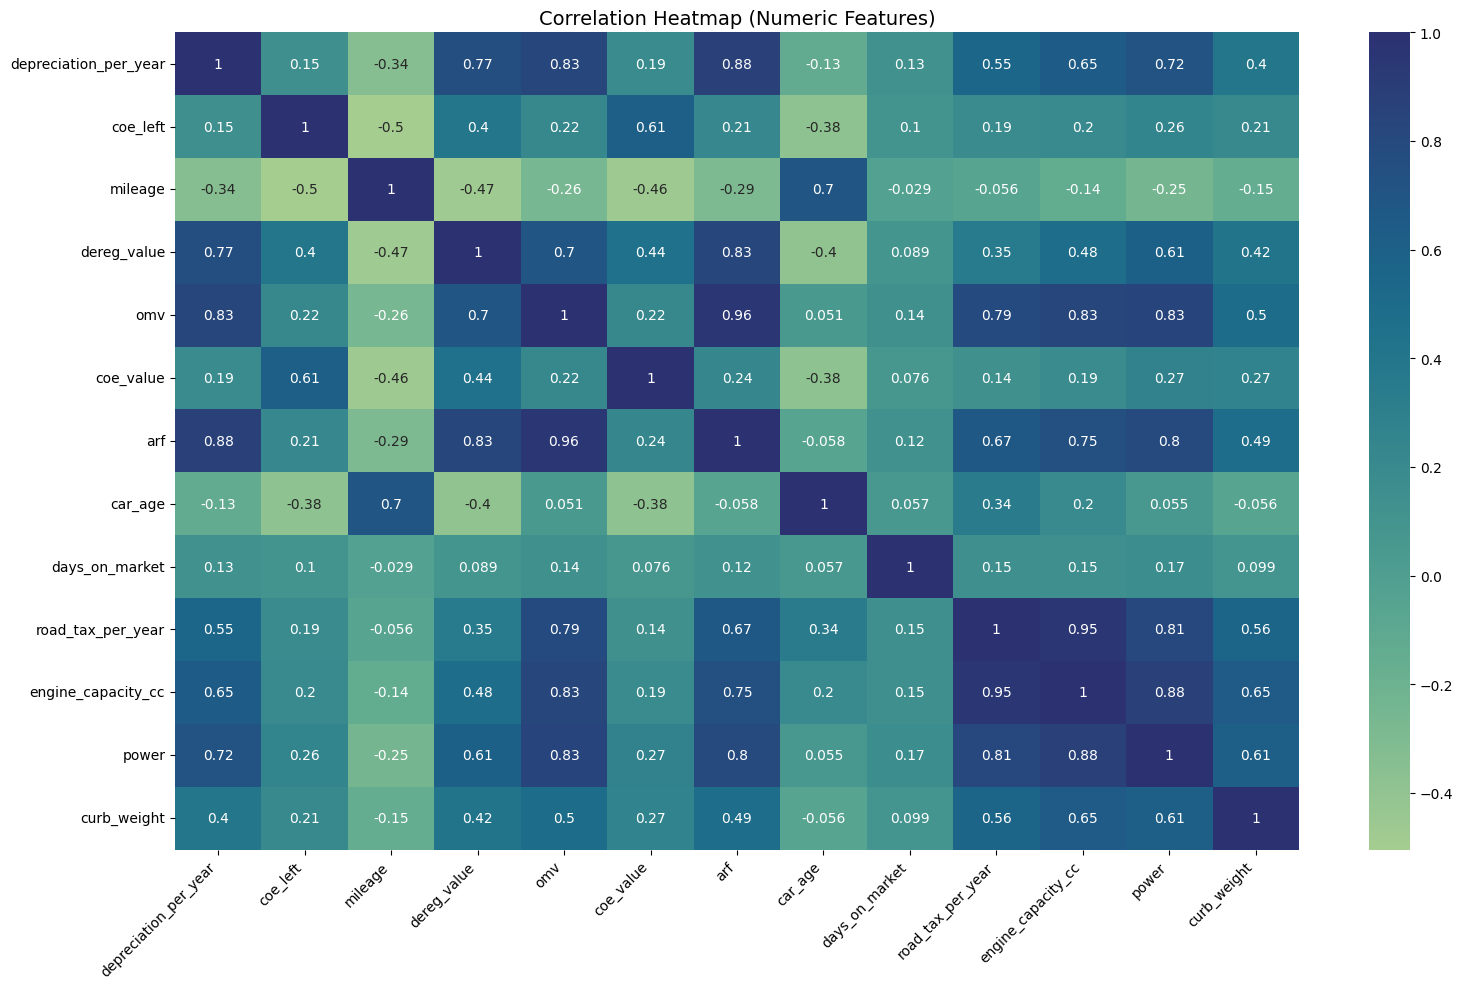

In [33]:
plt.figure(figsize=(16, 10))
numeric_cols = ['depreciation_per_year', 'coe_left', 'mileage', 'dereg_value', 'omv', 'coe_value', 'arf', 'car_age', 'days_on_market',
                'road_tax_per_year', 'engine_capacity_cc', 'power', 'curb_weight']
sns.heatmap(final_df[numeric_cols].corr(), annot=True, cmap="crest")


plt.title("Correlation Heatmap (Numeric Features)", fontsize=14)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

We can see that certain features are highly correlated, this could be due to reasons such as - the feature themselves are a derivation of the correlated feature. 
For example, 
- car_age is a derivation of the manufactured year and the current year.
- dereg_value contains ARF as a component in its calculation
- depreciation_per year is calculated using OMV and dereg_value
- road_tax is calculated using the power rating of the car's motor.

Therefore we will be removing `arf`, `depreciation_per_year`, `road_tax_per_year`


In [34]:
test_drop_df = final_df.drop(columns=['arf', 'depreciation_per_year', 'road_tax_per_year'])

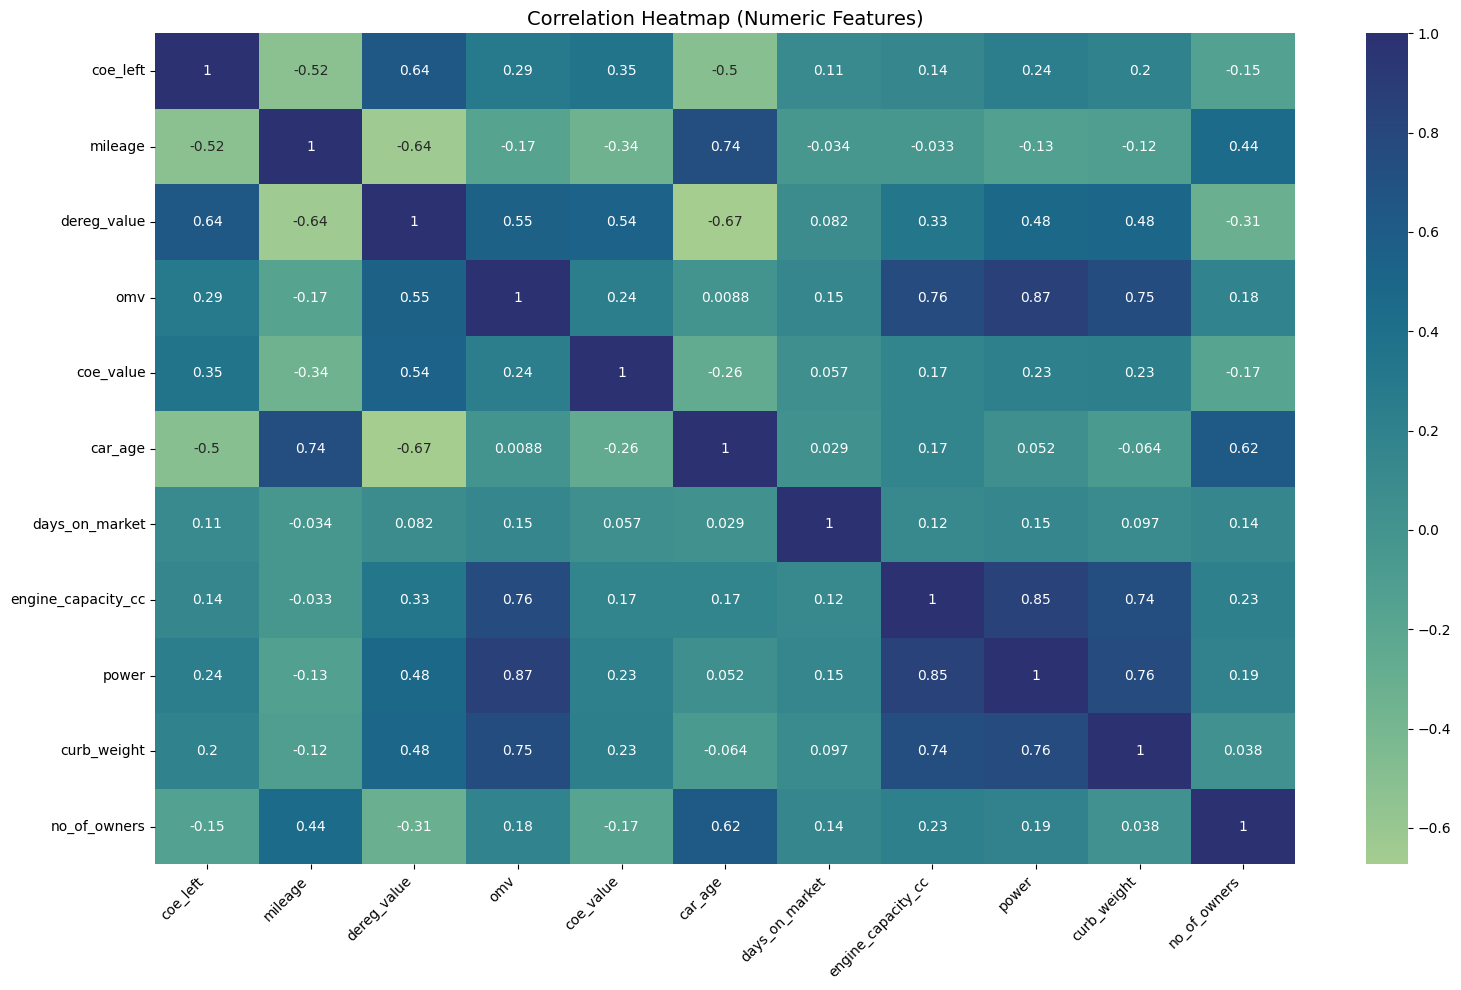

In [35]:
plt.figure(figsize=(16, 10))
numeric_cols_post = ['coe_left', 'mileage', 'dereg_value', 'omv', 'coe_value', 'car_age', 'days_on_market',
                'engine_capacity_cc', 'power', 'curb_weight', 'no_of_owners']
sns.heatmap(test_drop_df[numeric_cols_post].corr('spearman'), annot=True, cmap="crest") # Pearson for normal distribution, Spearman for non-normal distribution


plt.title("Correlation Heatmap (Numeric Features)", fontsize=14)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

## PCA
Instead of dropping variables arbitrarily, we can conduct PCA to obtain orthogonal features and conduct our feature selection this way

In [36]:
pca_cols = [col for col in numeric_cols if col != 'no_of_owners' and not col.startswith('embedding_')] # Number of owners is a discrete, categorical feature
pca_df = final_df.copy()[pca_cols]
pca_df.head()

,depreciation_per_year,coe_left,mileage,dereg_value,omv,coe_value,arf,car_age,days_on_market,road_tax_per_year,engine_capacity_cc,power,curb_weight
0,52920.0,3099,69200,97931.0,123866.0,122414.0,161026.0,22,49,4155.0,3246,261,1460
1,102380.0,3159,29000,110475.0,220263.0,138094.0,286342.0,22,24,4953.0,3586,305,1290
2,13190.0,3010,135000,93804.0,30485.0,117255.0,39631.0,22,10,1800.0,1988,114,1440
3,20080.0,3277,46000,84860.0,249670.0,106075.0,274637.0,21,24,10611.0,5998,412,2410
4,48050.0,3414,64700,81938.0,259435.0,102423.0,285379.0,21,27,10026.0,5748,380,1825


In [39]:
scaled_data = StandardScaler().fit_transform(pca_df[pca_cols])


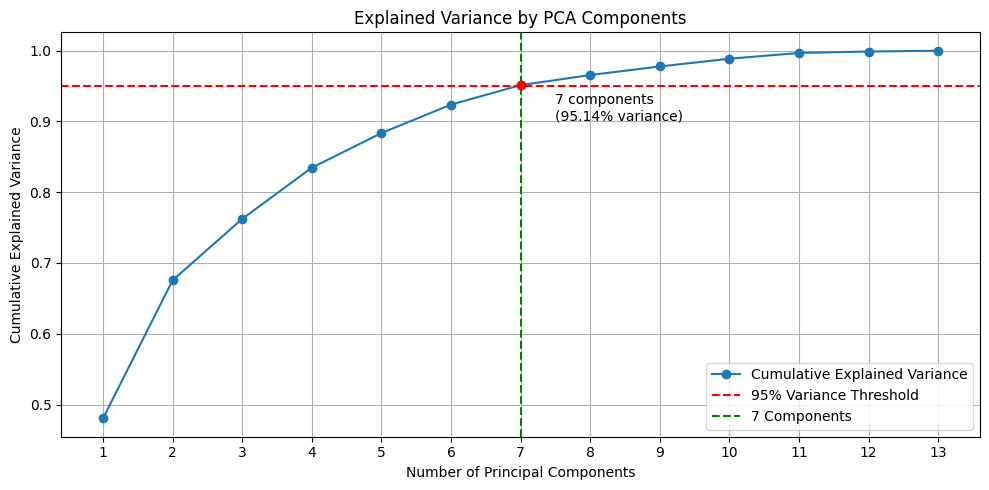

In [40]:
# 1. Run PCA (keep all components initially)
pca = PCA()
pca_components = pca.fit_transform(scaled_data)

# 2. Check variance explained
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# 3. Find how many components explain at least 95% variance
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# 4. Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=num_components_95, color='g', linestyle='--', label=f'{num_components_95} Components')

# 5. Annotate
plt.scatter(num_components_95, cumulative_variance[num_components_95-1], color='red', zorder=5)
plt.text(num_components_95 + 0.5, cumulative_variance[num_components_95-1] - 0.05,
         f"{num_components_95} components\n({cumulative_variance[num_components_95-1]*100:.2f}% variance)",
         color='black')

# 6. Labeling
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.legend()
plt.xticks(range(1, len(cumulative_variance)+1))
plt.tight_layout()
plt.show()

In choosing the number of principal components, we choose one that explains approximately explains 95% of the variance.
From the graph, it shows that 7 principal components explain approximately 95.14% of the variance

In [41]:
pca_7 = PCA(n_components=7)
pca_7_components = pca_7.fit_transform(scaled_data)
pca_7_df = pd.DataFrame(pca_7_components, columns=[f'PC{i+1}' for i in range(7)], index=final_df.index)

non_pca_cols = final_df.drop(columns=pca_cols).copy()  # These include 'no_of_owners' and any other non-numeric cols


combined_df = pd.concat([pca_7_df, non_pca_cols], axis=1)
combined_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,id,brand,color,fuel_type,price,transmission,no_of_owners,vehicle_type,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embeddi

In [42]:
def feature_engineer_dummys(df):
    """Creates dummy variables for categorical features.
    
    Args:
        df (pd.DataFrame): DataFrame containing car data
        
    Returns:
        pd.DataFrame: DataFrame with dummy variables added
    """
    df = df.copy()
    categorical_cols = ['brand', 'color', 'fuel_type', 'transmission', 'vehicle_type']
    # categorical_cols = ['brand', 'car_model', 'color', 'fuel_type', 'transmission', 'vehicle_type']

    for col in categorical_cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.strip()
                .str.lower()
                .str.replace(r'[^\w\s]', '', regex=True)  # Removes punctuation
            )
    
    # Create dummies for categorical features
    df = pd.get_dummies(
        df, 
        columns=categorical_cols,
        prefix_sep='_',
        drop_first=True  # Reduces multicollinearity by dropping first category
    )
    
    return df
df_dummy = feature_engineer_dummys(combined_df)
df_dummy.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,id,price,no_of_owners,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289

In [44]:
df_dummy.to_csv('feature-engineered_data.csv', index=False)

In [ ]:
"""
Data Cleaning -> Push cleaned dataset to bq -> feature engineering + one hot encoding
                        |                                   |-> Push feature engineered dataset to bq -> train the model                
                        |
                        |-> Data analytics pull bq dataset for data visualisation?
"""

'\nData Cleaning -> Push dataset to bq -> pull bq dataset -> feature engineering + one hot encoding -> train the model\n                        |\n                        |-> Data analytics pull bq dataset for data visualisation?\n'